# Test with KMNIST

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import umap

c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights

KMNIST downloaded.
Fast training of ResNet18 on MNIST
Extracting features
Computing UMAP projection


c:\Users\prete\miniconda3\envs\mach-learn\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


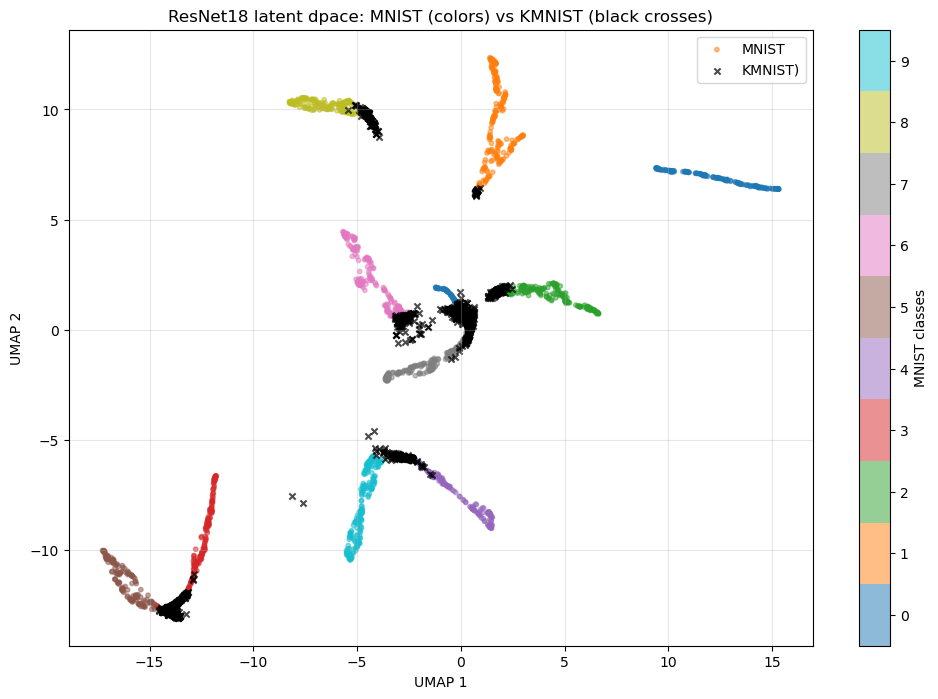

In [ ]:
# Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batchSize = 128

# ========================================
# Data preparation
# ========================================

# Identical transformation for both datasets
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST
mnistTrain = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
mnistTest = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# KMNIST
print("Downloading KMNIST")
kmnistTest = torchvision.datasets.KMNIST(root='./data', train=False, transform=transform, download=True)
print("KMNIST downloaded.")

# ========================================
# Model preparation
# ========================================

print("Fast training of ResNet18 on MNIST")
model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(512, 10)
model = model.to(device)

trainLoader = torch.utils.data.DataLoader(mnistTrain, batch_size=batchSize, shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

model.train()
for x, y in trainLoader:
    x, y = x.to(device), y.to(device)
    optimizer.zero_grad()
    logits = model(x)
    criterion(logits, y).backward()
    optimizer.step()

# ========================================
# Feature extraction
# ========================================

def getFeatures(dataset, numSamples):
    """ Extract features from a dataset using the model's body.

    :param dataset: Dataset to extract from
    :param numSamples: Number of samples to extract
    """
    indices = np.random.choice(len(dataset), numSamples, replace=False)
    subset = torch.utils.data.Subset(dataset, indices)
    loader = torch.utils.data.DataLoader(subset, batch_size=100)
    
    body = nn.Sequential(*list(model.children())[:-1])
    
    features = []
    labels = []
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            f = body(x).flatten(1)
            features.append(f.cpu().numpy())
            labels.append(y.numpy())
    return np.concatenate(features), np.concatenate(labels)

print("Extracting features")
xMNIST, yMNIST = getFeatures(mnistTest, 2000)
xKMNIST, yKMNIST = getFeatures(kmnistTest, 2000)

# ========================================
# UMAP projection
# ========================================

print("Computing UMAP projection")
# Train UMAP on MNIST
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embeddingMNIST = reducer.fit_transform(xMNIST)

# Project KMNIST onto this map
embeddingKMNIST = reducer.transform(xKMNIST)

# ========================================
# Visualization
# ========================================

plt.figure(figsize=(12, 8))
# Display MNIST (store the 'scatter' object in a variable)
scatterMNIST = plt.scatter(embeddingMNIST[:, 0], embeddingMNIST[:, 1], 
                            c=yMNIST, cmap='tab10', s=10, alpha=0.5, 
                            label='MNIST')

# Display KMNIST
plt.scatter(embeddingKMNIST[:, 0], embeddingKMNIST[:, 1], 
            c='black', marker='x', s=20, alpha=0.7, 
            label='KMNIST)')

# Colorbar for MNIST classes
cbar = plt.colorbar(scatterMNIST, boundaries=np.arange(11)-0.5)
cbar.set_ticks(np.arange(10))
cbar.set_label('MNIST classes')

# Legend
plt.legend(loc='upper right') # force position to avoid hiding data
plt.title("ResNet18 latent dpace: MNIST (colors) vs KMNIST (black crosses)")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.grid(True, alpha=0.3)
plt.show()

__________________
__________________